In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
import tensorflow as tf

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import models, Input, Model
from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout

In [ ]:
from sklearn.model_selection import train_test_split

## 1. Data Load

In [ ]:
url = "https://raw.githubusercontent.com/Kwang-wan/Project_AI/main/data/Trash_Comment.csv"

data = pd.read_csv(url)

data.head()

,text,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23721 entries, 0 to 23720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23721 non-null  object
 1   label   23721 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


## 2. Data Cleansing

In [ ]:
def clean(data) :
  data['text'] = data['text'].str.replace("[^가-힣A-Za-z0-9(),!?\'\`]" , " ")
  data['text'] = data['text'].str.replace("," , " , ")  
  data['text'] = data['text'].str.replace("!" , " ! ")
  data['text'] = data['text'].str.replace("\(" , " \( ") 
  data['text'] = data['text'].str.replace("\)" , " \) ")
  data['text'] = data['text'].str.replace("?" , " ? ")   
  data['text'] = data['text'].str.replace("\s{2,}" , " ")  
  data['text'] = data['text'].str.replace("\'{2,}" , "\'")  
  data['text'] = data['text'].str.replace("\'" , "")  

In [ ]:
clean(data)

In [ ]:
data.head()

,text,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 ? ? 좀 신선했었지 ...,1
1,씨바알 노무노무 술프노 오늘 저녁은 꽂등심이다,1
2,짱깨 꺼라 패쓰,1
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소용...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


In [ ]:
stopwords = ['의', '가', '이', '은', '들', '는',
             '좀', '잘', '걍', '과', '도',
             '를', '으로', '자', '에', '와', '한', '하다']

### 2) 토큰화, 불용어 제거

In [ ]:
%%time

okt = Okt()
tokenized_data = []

for sentence in data['text'] :
  temp_X = okt.morphs(sentence, stem = True) # 토큰화(형태소 별로 나눠짐)
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

CPU times: user 1min 30s, sys: 998 ms, total: 1min 31s
Wall time: 1min 17s


In [ ]:
for i in range(5):
  print(tokenized_data[i])

['이종석', '한효주', '나오다', '드라마', '이후', '로', '드라마', '안', '보다', '2년', '전인가', '?', '?', '신선하다', '근데', '이렇다', '개막', '장', '드라마', '도대체', '누가', '보다', '면', '변태', '보다', '것', '이다', '정상', '적', '인', '사람', '채널', '을', '돌리다', '되다']
['씨', '바알', '노무', '노무', '술프노', '오늘', '저녁', '꽂다', '등심', '이다']
['짱깨', '끄다', '패쓰']
['그', '사생활', '고인', '되다', '설리', '위', '모두', '조용하다', '지금', '누굴', '탓', '무슨', '소', '용이', '있다']
['아무리', '법', '뭣같아', '무슨', '자격', '개인', '신상', '정보', '불', '특정', '다수', '에게', '공개', '도저히', '이해', '안되다', '법', '을', '바꾸다', '위해', '노력', '저런', '능력', '불법', '적', '인', '일', '을', '공공', '이익', '포장', '말다']


### 3) 리뷰 길이 확인

In [ ]:
print('댓글 최대 길이: ' , max(len(l) for l in tokenized_data))
print('댓글 평균 길이: ' , sum(map(len, tokenized_data))/len(tokenized_data))

댓글 최대 길이:  408
댓글 평균 길이:  12.529868049407698


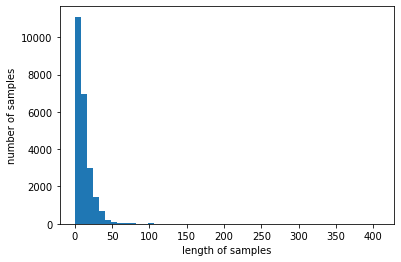

In [ ]:
plt.hist([len(f) for f in tokenized_data] , bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 4) 50단어 이하로 길이 제한, 패딩

In [ ]:
sentences_new = []

for sentence in tokenized_data:
  sentences_new.append([word for word in sentence][:50])

tokenized_data = sentences_new

for i in range(5) :
  print(tokenized_data[i]) 

['이종석', '한효주', '나오다', '드라마', '이후', '로', '드라마', '안', '보다', '2년', '전인가', '?', '?', '신선하다', '근데', '이렇다', '개막', '장', '드라마', '도대체', '누가', '보다', '면', '변태', '보다', '것', '이다', '정상', '적', '인', '사람', '채널', '을', '돌리다', '되다']
['씨', '바알', '노무', '노무', '술프노', '오늘', '저녁', '꽂다', '등심', '이다']
['짱깨', '끄다', '패쓰']
['그', '사생활', '고인', '되다', '설리', '위', '모두', '조용하다', '지금', '누굴', '탓', '무슨', '소', '용이', '있다']
['아무리', '법', '뭣같아', '무슨', '자격', '개인', '신상', '정보', '불', '특정', '다수', '에게', '공개', '도저히', '이해', '안되다', '법', '을', '바꾸다', '위해', '노력', '저런', '능력', '불법', '적', '인', '일', '을', '공공', '이익', '포장', '말다']


In [ ]:
%%time

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(tokenized_data)

X = tokenizer.texts_to_sequences(tokenized_data)
X = pad_sequences(X)

print(X[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  2226  1606    26   101   785    12   101    11     3
   1223  6337     1     1  2016    87    90  3943   493   101   647   200
      3    52  2927     3    60    17   772    55    49    16   847     4
    516     8]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    80  6338  1518  1518  9319   280  2734  2227
   9320    17]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0   553
    141  9321]
 [    0     0     0     0     0     0     0     0     0     0     0

## 4. X, y split

In [ ]:
X.shape

(23721, 50)

In [ ]:
y = np.array([[label] for label in data['label']])

y.shape

(23721, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state = 2046)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18976, 50), (4745, 50), (18976, 1), (4745, 1))

## 5. Modeling
- query shape: (batch_size, hidden size)
- hidden_with_time_axis shape: (batch_size, 1, hidden size)
- score shape: (batch_size, max_length, 1)
- attention_weight shape: (batch_size, max_length, 1)


In [ ]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    
    attention_weights = tf.nn.softmax(score, axis = 1)

    context_vector = attention_weights * values
    contect_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights

### 1) 입력층과 임베딩층 설계

In [ ]:
sequence_input = Input(shape = (50, ), dtype = 'int32')
embedded_sequences = Embedding(20000, 256,
                               input_length = 50,
                               mask_zero = True)(sequence_input)

- 첫번째 양방향 LSTM 층

In [ ]:
lstm = Bidirectional(
    LSTM(128, dropout = 0.5, return_sequences = True))(embedded_sequences)

- 두번째 양방향 LSTM 층

In [ ]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(
    LSTM(128, dropout = 0.5, return_sequences = True, return_state = True))(lstm)

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 50, 256) (None, 128) (None, 128) (None, 128) (None, 128)


- 두 방향 LSTM 상태들을 연결

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

- 컨텍스트 벡터 얻기

In [ ]:
attention = BahdanauAttention(128)
context_vector, attention_weights = attention(lstm, state_h)

- 컨텍스트 벡터를 밀집층에 통과

In [ ]:
dense1 = Dense(20, activation = 'relu')(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation = 'sigmoid')(dropout)

model = Model(inputs = sequence_input, outputs = output)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 256)      5120000     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 50, 256)      394240      embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) [(None, 50, 256), (N 394240      bidirectional_8[0][0]            
____________________________________________________________________________________________

- 옵티마이저 설정 후 컴파일

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
%%time 

history = model.fit(X_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_data = (X_test, y_test),
                    verbose = 1)

Epoch 1/10
149/149 [==============================] - 129s 735ms/step - loss: 0.6859 - accuracy: 0.5412 - val_loss: 0.6473 - val_accuracy: 0.5922
Epoch 2/10
149/149 [==============================] - 95s 641ms/step - loss: 0.6301 - accuracy: 0.6034 - val_loss: 0.6259 - val_accuracy: 0.5951
Epoch 3/10
149/149 [==============================] - 95s 640ms/step - loss: 0.5905 - accuracy: 0.6160 - val_loss: 0.6202 - val_accuracy: 0.6024
Epoch 4/10
149/149 [==============================] - 95s 639ms/step - loss: 0.5710 - accuracy: 0.6287 - val_loss: 0.6342 - val_accuracy: 0.6028
Epoch 5/10
149/149 [==============================] - 95s 637ms/step - loss: 0.5522 - accuracy: 0.6356 - val_loss: 0.6465 - val_accuracy: 0.6028
Epoch 6/10
149/149 [==============================] - 94s 631ms/step - loss: 0.5466 - accuracy: 0.6359 - val_loss: 0.6627 - val_accuracy: 0.6043
Epoch 7/10
149/149 [==============================] - 92s 620ms/step - loss: 0.5391 - accuracy: 0.6381 - val_loss: 0.6775 - val_a